# Bayesian Neural Network in PyMC3
(c) 2016 by Thomas Wiecki

In [1]:
import sys, os
sys.path.insert(0, os.path.expanduser('~/work/git/github/taku-y/pymc3/'))

%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
import seaborn as sns

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Program Files\WinPython-64bit-3.6.5.0\python-3.6.5.amd64\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Program Files\WinPython-64bit-3.6.5.0\python-3.6.5.amd64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which a

In [2]:
#X, Y = datasets.make_blobs(n_samples=200, n_features=2, centers=2, cluster_std=3.0, 
#                           center_box=(-5.0, 5.0), shuffle=True, random_state=None)

X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype('float32')
Y = Y.astype('float32')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

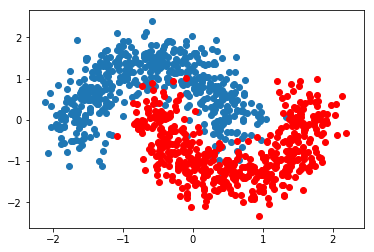

In [3]:
plt.scatter(X[Y==0, 0], X[Y==0, 1])
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r')

In [4]:
def Ordered(name, var, model=None):
    order = T.constant(list(range(var.tag.test_value.shape[1])))
    return pm.Potential(
        name,
        T.switch(T.eq(T.argsort(T.sum(var, axis=0)), order), 0, -np.inf),
        model=model
    )

In [5]:
# Turn inputs and outputs into shared variables so that we can change them later
import theano.tensor as tt

# ann_input = tt.matrix()
# ann_input.tag.test_value = X_train
# ann_output = tt.vector()
# ann_output.tag.test_value = Y_train

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 5

# Initialize random but sorted starting weights.
init_1 = np.random.randn(X.shape[1], n_hidden)
init_1 = init_1[:, np.argsort(init_1.sum(axis=0))]
init_2 = np.random.randn(n_hidden, n_hidden)
init_2 = init_2[:, np.argsort(init_2.sum(axis=0))]
init_out = np.random.randn(n_hidden)
init_out = init_out[np.argsort(init_out)]

    
with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(X.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden, n_hidden), 
                             testval=init_2)
    
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, shape=(n_hidden,), 
                              testval=init_out)

    # Build neural-network
    a1 = T.dot(ann_input, weights_in_1)
    act_1 = T.tanh(a1)
    a2 = T.dot(act_1, weights_1_2)
    act_2 = T.tanh(a2)
    act_out = T.dot(act_2, weights_2_out)
    
    out = pm.Bernoulli('out', 
                       T.nnet.sigmoid(act_out),
                       observed=ann_output)

## Estimation with ADVI

In [6]:
minibatch_tensors = [ann_input, ann_output]
minibatch_RVs = [out]

def create_minibatch(data):
    rng = np.random.RandomState(0)
    
    while True:
        ixs = rng.randint(len(data), size=100)
        yield data[ixs]

minibatches = [
    create_minibatch(X_train), 
    create_minibatch(Y_train),
]

total_size = len(Y_train)

In [7]:
with neural_network:
    # Run advi_minibatch
    advi_fit = pm.variational.advi_minibatch(
        n=40000, minibatch_tensors=minibatch_tensors, 
        minibatch_RVs=minibatch_RVs, minibatches=minibatches, 
        total_size=total_size, learning_rate=1e-2, epsilon=1.0, 
        n_mcsamples=1
    )
plt.plot(advi_fit.elbo_vals)
trace_advi = pm.variational.sample_vp(advi_fit, 500, neural_network)

AttributeError: module 'pymc3.variational' has no attribute 'advi_minibatch'

In [ ]:
# Replace shared variables with testing set
# (note that using this trick we could be streaming ADVI for big data)
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace_advi, model=neural_network, samples=500)
pred = ppc['out'].mean(axis=0) > 0.5

plt.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1])
plt.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
plt.title('Predicted labels in testing set')

In [ ]:
plt.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
plt.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
plt.title('Predicted labels in testing set')

In [ ]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))
sns.regplot(ppc['out'].mean(axis=0), Y_test, logistic=True)

## Lets look at what the classifier has learned

In [ ]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T.astype('float32')
dummy_out = np.ones(grid_2d.shape[0], dtype=np.int8)

ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)
# Creater posterior predictive samples
ppc = pm.sample_ppc(trace_advi, model=neural_network, samples=5000)
pred_grid = ppc['out'].mean(axis=0)

In [ ]:
cmap = sns.diverging_palette(145, 280, s=85, l=25, as_cmap=True)
# plt.contourf(*grid, pred_grid.reshape(100, 100), cmap=cmap)
plt.contourf(grid[0], grid[1], pred_grid.reshape(100, 100), cmap=cmap)
plt.scatter(X_test[pred==0, 0], X_test[pred==0, 1], alpha=0.5)
plt.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r', alpha=0.5)
#plt.title('Predicted labels in testing set')